In [192]:
import json
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import re
import seaborn as sns

from classifier import *
from heapq import nlargest
from issues import get_num_code_lines
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Pre-Processing

In [193]:
with open('../data/flutter/flutter_issues_prs.json') as json_data:
    issues_prs = json.load(json_data)
ret = []
for issue in issues_prs:
    if issue['failed_prs']:
        ret.append(issue)
print(ret[:5])

[{'issue_num': 83, 'merged_prs': [{'pull': '/flutter/engine/pull/2397', 'author': None}, {'pull': '/flutter/engine/pull/2397', 'author': None}], 'failed_prs': [{'pull': '/flutter/flutter/pull/1851', 'author': 'abarth'}], 'master_commits': [], 'local_commits': [{'commit': '/abarth/flutter/commit/3d51d6a6ff48a7c1a119bc82e6a3a7dea2121007', 'author': 'abarth'}]}, {'issue_num': 138, 'merged_prs': [{'pull': '/flutter/website/pull/164', 'author': 'eseidelGoogle'}, {'pull': '/flutter/flutter/pull/5484', 'author': None}, {'pull': '/flutter/flutter/pull/5484', 'author': None}], 'failed_prs': [{'pull': '/flutter/flutter/pull/5498', 'author': 'bbalet'}], 'master_commits': [], 'local_commits': []}, {'issue_num': 215, 'merged_prs': [{'pull': '/flutter/flutter/pull/1303', 'author': 'abarth'}, {'pull': '/flutter/flutter/pull/1078', 'author': None}, {'pull': '/flutter/flutter/pull/1078', 'author': None}], 'failed_prs': [{'pull': '/flutter/flutter/pull/1078', 'author': 'Hixie'}], 'master_commits': [], '

In [194]:
with open('../data/flutter/flutter_issues_labeled.json') as json_data:
    issues = json.load(json_data)

In [195]:
print("Number of issues: " + str(len(issues)))
labeled_issues = [issue for issue in issues if len(issue['completed_by']) > 0]
print("Number of labeled issues: " + str(len(labeled_issues)))

Number of issues: 7170
Number of labeled issues: 2504


In [196]:
# create a data frame from the list of issues
df_list = []
for issue in labeled_issues[25:]:
        df_dict = {}
        df_dict['comments'] = issue['comments']
        if (not issue['body']):
            issue['body'] = ""
        df_dict['title'] = issue['title']
        df_dict['body'] = issue['body']
        df_dict['closed_date'] = pd.to_datetime(issue['closed_at'])
        df_dict['created_date'] = pd.to_datetime(issue['created_at'])
        df_dict['completed_by'] = issue['completed_by']
        df_dict['labels'] = [label['name'] for label in issue['labels']]
        df_dict['assignees'] = [assignee['login'] for assignee in issue['assignees']]
        df_list.append(df_dict)
df = pd.DataFrame(df_list).sort_values('closed_date')
df.head(2)

,assignees,body,closed_date,comments,completed_by,created_date,labels,title
1,[abarth],When I try to `flutter start` any of the examp...,2015-11-09 20:13:32,3,"[abarth, DanTup]",2015-11-08 20:33:37,"[easy fix, tool]",`flutter start` doesn't give good error messag...
6,[],"<a href=""https://github.com/Hixie""><img src=""h...",2015-11-09 20:18:24,1,[yjbanov],2015-11-09 20:16:52,"[framework, severe: new feature]",Swipe to change between Tabs


In [197]:
print(len(df))
df_temp = df[df.apply(lambda x: len(x['assignees']) != 0, axis=1)].reset_index(drop=True)
print(len(df_temp))
df_temp.head(10)

2479
1540


,assignees,body,closed_date,comments,completed_by,created_date,labels,title
0,[abarth],When I try to `flutter start` any of the examp...,2015-11-09 20:13:32,3,"[abarth, DanTup]",2015-11-08 20:33:37,"[easy fix, tool]",`flutter start` doesn't give good error messag...
1,[abarth],flutter start --debug\nsevere: To copy files t...,2015-11-09 21:43:40,1,[abarth],2015-11-09 20:50:45,[tool],Exception running source build of engine on Mac
2,[collinjackson],cc @tvolkert \n,2015-11-10 00:40:38,1,[collinjackson],2015-11-09 21:07:13,[],Implement Dart's HTTP package in Flutter with ...
3,[abarth],When the widget is created with an initial str...,2015-11-11 17:56:29,3,[abarth],2015-11-11 00:57:05,"[a: text input, framework, severe: regression]",Cursor in TextInput is displayed incorrectly
4,[abarth],In components that take a `List<T>` and an `It...,2015-11-12 20:25:12,0,[abarth],2015-11-12 06:10:10,"[easy fix, framework]",ItemBuilder should also get the index of the i...
5,[HansMuller],cc @HansMuller \n,2015-11-13 00:40:47,0,[HansMuller],2015-11-12 20:27:39,"[framework, severe: regression, ⚠ TODAY]",closing the menu in stocks throws an exception
6,[abarth],This is similar to an old issue from the old i...,2015-11-13 00:58:57,4,[abarth],2015-11-12 22:25:34,"[framework, severe: regression]",Updated Widget is sized wrong (but placed corr...
7,[abarth],RenderEditableParagraph width looks as if it w...,2015-11-13 19:19:02,7,[abarth],2015-11-11 11:50:37,"[a: text input, framework]","When there's no text in an input widget, the c..."
8,[HansMuller],Currently if you tap on a stock row (to bring ...,2015-11-16 20:00:10,0,[HansMuller],2015-11-16 19:28:51,[severe: regression],Stocks demo tap fails if BottomSheet is visible
9,[collinjackson],,2015-11-16 22:35:59,0,"[devoncarew, collinjackson]",2015-11-13 23:19:50,"[easy fix, tool]",flutter logs --c should be a synonym for flutt...


In [198]:
# count number of issues with multiple completers
counts = {}
for index, row in df.iterrows():
    count = len(row['completed_by'])
    counts[count] = counts.get(count, 0) + 1
print(counts)
#TODO: confirm that filtering "noise" is best strategy here
print("Number of total issues: " + str(len(df)))
df = df[df.apply(lambda x: len(x['completed_by']) == 1, axis=1)].reset_index(drop=True)
df['completed_by'] = df['completed_by'].apply(lambda  x : x[0])
print("Number of issues with single solver: " + str(len(df)))

{2: 197, 1: 2268, 3: 14}
Number of total issues: 2479
Number of issues with single solver: 2268


In [199]:
# one hot encode the label column
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('labels')),
                          columns=mlb.classes_,
                          index=df.index))
df.head(2)

,assignees,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,...,team: gallery,tool,waiting for PR to land (fixed),waiting for customer response,⌘‬ platform-mac,⌺‬ platform-ios,▣ platform-android,○ platform-fuchsia,⚠ TODAY,❖ platform-windows
0,[],"<a href=""https://github.com/Hixie""><img src=""h...",2015-11-09 20:18:24,1,yjbanov,2015-11-09 20:16:52,Swipe to change between Tabs,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[abarth],flutter start --debug\nsevere: To copy files t...,2015-11-09 21:43:40,1,abarth,2015-11-09 20:50:45,Exception running source build of engine on Mac,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [200]:
def preprocess(text):
    stemmer = PorterStemmer()
    # remove punctuation and non-alpha numeric characters
    split1 = ' '.join([word for word in re.split('\W+', text) if word.isalpha()])
    # split camel case words apart (necessary for embedded code) and apply stemmer to all words
    split2 = ' '.join([stemmer.stem(word) for word in re.sub('(?!^)([A-Z][a-z]+)', r' \1', split1).split()])
    return split2

In [201]:
# use tf-idf w/ stemming, stop-word removal, and non-alphabetic word removal to generate features
df['body'] = df['body'].apply(preprocess)
vectorizer_body = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer_body.fit(df['body'])
vector_body = vectorizer_body.transform(df['body'])
# summarize encoded vector
print(vector_body.shape)
df['title'] = df['title'].apply(preprocess)
vectorizer_title = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS)
vectorizer_title.fit(df['title'])
vector_title = vectorizer_title.transform(df['title'])
# summarize encoded vector
print(vector_title.shape)

(2268, 4960)
(2268, 1804)


In [202]:
title_df = pd.DataFrame(vector_title.todense())
body_df = pd.DataFrame(vector_body.todense())
df = pd.concat([df, title_df, body_df], axis=1)
df.head(2)

,assignees,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
0,[],a href http github com hixi img src http avata...,2015-11-09 20:18:24,1,yjbanov,2015-11-09 20:16:52,swipe to chang between tab,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,[abarth],flutter start debug sever To copi file to io d...,2015-11-09 21:43:40,1,abarth,2015-11-09 20:50:45,except run sourc build of engin on mac,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
# get list of devs who solve an issue in last three months (from end of train set)
active_devs = set()
dev_counts = {}
filter_date = df.iloc[2000]['closed_date'] - pd.to_timedelta(90, unit='d')
for _, row in df.iterrows():
    if (row['closed_date'] > filter_date):
        dev_counts[row['completed_by']] = dev_counts.get(row['completed_by'], 0) + 1
print(dev_counts)
for dev in dev_counts:
    if dev_counts[dev] >= 1:
        active_devs.add(dev)
print(active_devs)
# remove all issues not solved by an active dev
df = df[df['completed_by'].isin(active_devs)].reset_index(drop=True)
print(len(df))

{'jason-simmons': 21, 'aam': 27, 'yjbanov': 16, 'cbracken': 34, 'Hixie': 33, 'gspencergoog': 10, 'xster': 50, 'goderbauer': 41, 'a-siva': 1, 'chinmaygarde': 1, 'mravn-google': 21, 'HansMuller': 35, 'abarth': 1, 'tvolkert': 17, 'amirh': 4, 'Skylled': 1, 'leobispo': 1, 'sigurdm': 1, 'mehmetf': 1, 'fredriks': 1, 'jakobr-google': 1, 'crelier': 1, 'alibitek': 1, 'mit-mit': 3, 'jcollins-g': 11, 'dnfield': 2, 'DanTup': 5, 'mraleph': 4, 'rmacnak-google': 1, 'DaveShuckerow': 2, 'szakarias': 3, 'xqwzts': 5, 'jonahwilliams': 27, 'danrubel': 1, 'konifar': 2, 'sroddy': 1, 'matanlurey': 1, 'srawlins': 1, 'sbaranov': 1, 'OhadRau': 1, 'scheglov': 2, 'filleduchaos': 1, 'blasten': 2, 'mattsarett': 1, 'devoncarew': 6, 'liyuqian': 1, 'slightfoot': 2, 'ng1905': 1, 'fmatosqg': 2, 'paulcbetts': 1}
{'mravn-google', 'yjbanov', 'liyuqian', 'gspencergoog', 'amirh', 'ng1905', 'HansMuller', 'paulcbetts', 'OhadRau', 'DanTup', 'sroddy', 'fmatosqg', 'blasten', 'fredriks', 'sigurdm', 'szakarias', 'jonahwilliams', 'leo

# Machine Learning

In [204]:
train_df = df[:1100]
test_df = df[1100:]
X_train = train_df.drop(['body', 'closed_date', 'completed_by', 'created_date', 'title', 'comments', 'assignees'], axis=1)
y_train = train_df['completed_by']
X_test = test_df.drop(['body', 'closed_date', 'completed_by', 'created_date', 'title', 'comments', 'assignees'], axis=1)
y_test = test_df['completed_by']
print(len(X_train))
print(len(X_test))

1100
937


In [205]:
def is_correct_top_k(pred_prob, k, actual, labels):
    indices = [i for i in range(len(pred_prob))]
    top_indices = nlargest(k, indices, key=lambda i: pred_prob[i])
    top_choices = set([labels[i] for i in top_indices])
    return actual in top_choices

In [206]:
classifier = MLPClassifier(hidden_layer_sizes=(25,25))
classifier.fit(X_train,y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.22411953041622198
Top 2 Accuracy: 0.3287086446104589
Top 3 Accuracy: 0.3810032017075774
Top 4 Accuracy: 0.4247598719316969
Top 5 Accuracy: 0.4621131270010672


In [207]:
classifier = GaussianNB()
classifier.fit(X_train,y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.13233724653148346
Top 2 Accuracy: 0.1376734258271078
Top 3 Accuracy: 0.21558164354322304
Top 4 Accuracy: 0.288153681963714
Top 5 Accuracy: 0.29242262540021347


In [208]:
classifier = BernoulliNB()
classifier.fit(X_train,y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.1056563500533618
Top 2 Accuracy: 0.23372465314834578
Top 3 Accuracy: 0.30202774813233724
Top 4 Accuracy: 0.3265741728922092
Top 5 Accuracy: 0.3810032017075774


In [209]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.19637139807897544
Top 2 Accuracy: 0.2529348986125934
Top 3 Accuracy: 0.3073639274279616
Top 4 Accuracy: 0.33938100320170755
Top 5 Accuracy: 0.3511205976520811


In [210]:
classifier = RandomForestClassifier(n_estimators=1000)
classifier.fit(X_train, y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))

Top 1 Accuracy: 0.18569903948772679
Top 2 Accuracy: 0.29242262540021347
Top 3 Accuracy: 0.35432230522945574
Top 4 Accuracy: 0.39807897545357523
Top 5 Accuracy: 0.4407684098185699


In [211]:
'''
#TODO: try SVC (might need to do something else)
classifier = SVC(probability=True)
classifier.fit(X_train, y_train)
classes = classifier.classes_
print("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))
pred_probs = classifier.predict_proba(X_test)
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):
        correct += 1
print ("Top 2 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):
        correct += 1
print ("Top 3 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):
        correct += 1
print ("Top 4 Accuracy: " + str((correct/len(y_test))))
correct = 0
for idx, pred in enumerate(pred_probs):
    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):
        correct += 1
print ("Top 5 Accuracy: " + str((correct/len(y_test))))
'''

'\n#TODO: try SVC (might need to do something else)\nclassifier = SVC(probability=True)\nclassifier.fit(X_train, y_train)\nclasses = classifier.classes_\nprint("Top 1 Accuracy: " + str(classifier.score(X_test, y_test)))\npred_probs = classifier.predict_proba(X_test)\ncorrect = 0\nfor idx, pred in enumerate(pred_probs):\n    if is_correct_top_k(pred, 2, y_test[1100 + idx], classes):\n        correct += 1\nprint ("Top 2 Accuracy: " + str((correct/len(y_test))))\ncorrect = 0\nfor idx, pred in enumerate(pred_probs):\n    if is_correct_top_k(pred, 3, y_test[1100 + idx], classes):\n        correct += 1\nprint ("Top 3 Accuracy: " + str((correct/len(y_test))))\ncorrect = 0\nfor idx, pred in enumerate(pred_probs):\n    if is_correct_top_k(pred, 4, y_test[1100 + idx], classes):\n        correct += 1\nprint ("Top 4 Accuracy: " + str((correct/len(y_test))))\ncorrect = 0\nfor idx, pred in enumerate(pred_probs):\n    if is_correct_top_k(pred, 5, y_test[1100 + idx], classes):\n        correct += 1\np

# Analysis

In [212]:
classifier = MLPClassifier(hidden_layer_sizes=(25,25))
classifier.fit(X_train,y_train)
preds = classifier.predict(X_test)
print(preds)

['abarth' 'chinmaygarde' 'abarth' 'aam' 'HansMuller' 'abarth' 'abarth'
 'jakobr-google' 'devoncarew' 'devoncarew' 'abarth' 'devoncarew' 'Hixie'
 'goderbauer' 'abarth' 'Hixie' 'tvolkert' 'abarth' 'danrubel' 'abarth'
 'abarth' 'devoncarew' 'jason-simmons' 'danrubel' 'devoncarew' 'cbracken'
 'aam' 'abarth' 'yjbanov' 'aam' 'abarth' 'jakobr-google' 'abarth'
 'HansMuller' 'jakobr-google' 'abarth' 'yjbanov' 'abarth' 'aam' 'Hixie'
 'abarth' 'tvolkert' 'jonahwilliams' 'abarth' 'tvolkert' 'cbracken'
 'cbracken' 'devoncarew' 'devoncarew' 'goderbauer' 'abarth' 'Hixie'
 'abarth' 'Hixie' 'Hixie' 'goderbauer' 'cbracken' 'Hixie' 'Hixie' 'Hixie'
 'abarth' 'chinmaygarde' 'devoncarew' 'abarth' 'cbracken' 'HansMuller'
 'abarth' 'cbracken' 'Hixie' 'tvolkert' 'HansMuller' 'Hixie' 'tvolkert'
 'aam' 'devoncarew' 'Hixie' 'abarth' 'abarth' 'abarth' 'abarth' 'abarth'
 'devoncarew' 'devoncarew' 'cbracken' 'abarth' 'goderbauer'
 'jakobr-google' 'abarth' 'yjbanov' 'Hixie' 'abarth' 'abarth' 'abarth'
 'abarth' 'HansM

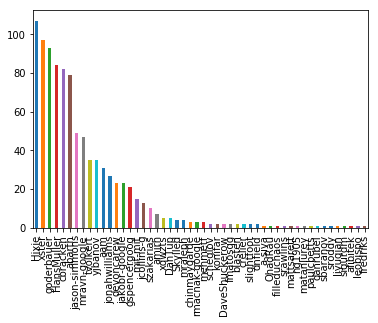

In [213]:
actual = test_df['completed_by']
pd.value_counts(actual).plot.bar()

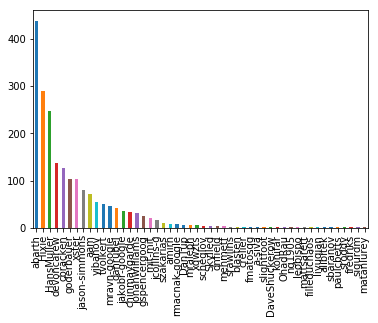

In [214]:
pd.value_counts(df['completed_by']).plot.bar()

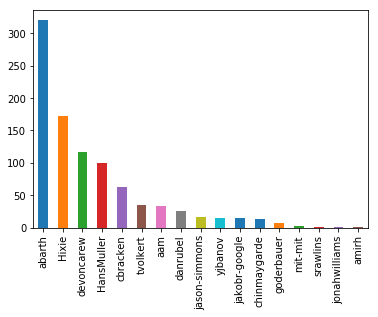

In [215]:
pd.value_counts(preds).plot.bar()

In [216]:
overall_counts = pd.value_counts(df['completed_by'])
# list of devs sorted in order of highest contribution
sorted_dev_list = overall_counts.index.values
pred_counts = pd.value_counts(preds)
actual_counts = pd.value_counts(actual)

percent_diff = {}
vals = []
counts = []
missing = set()
for dev in sorted_dev_list:
    if dev in pred_counts:
        val = 100 * (pred_counts[dev] - actual_counts[dev]) / (actual_counts[dev])
        percent_diff[dev] = val
        counts.append(overall_counts[dev])
        vals.append(val)
    else:
        missing.add(dev)
print("devs not included in predictions: ")
print(list(missing))

devs not included in predictions: 
['mravn-google', 'liyuqian', 'gspencergoog', 'ng1905', 'paulcbetts', 'OhadRau', 'DanTup', 'sroddy', 'fmatosqg', 'blasten', 'fredriks', 'sigurdm', 'szakarias', 'leobispo', 'a-siva', 'slightfoot', 'dnfield', 'crelier', 'rmacnak-google', 'filleduchaos', 'mehmetf', 'sbaranov', 'alibitek', 'xqwzts', 'matanlurey', 'mraleph', 'xster', 'Skylled', 'mattsarett', 'DaveShuckerow', 'jcollins-g', 'konifar', 'scheglov']


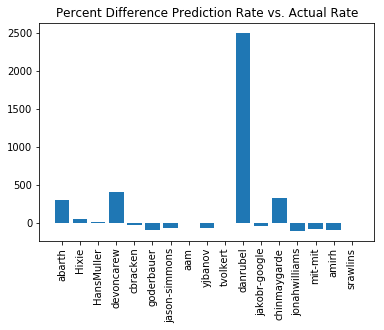

In [217]:
plt.bar(percent_diff.keys(), percent_diff.values())
plt.title("Percent Difference Prediction Rate vs. Actual Rate")
plt.xticks(rotation=90)
plt.show()

R^2: 1.7007984266280246e-06


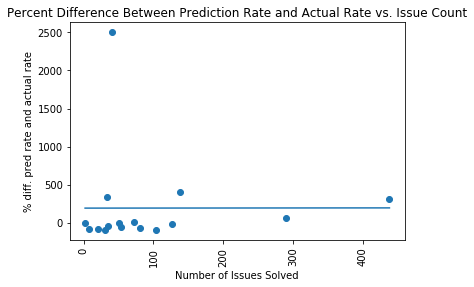

In [218]:
# remove the outlier
del vals[2]
del counts[2]
# create best fit line
z = np.polyfit(x=counts, y=vals, deg=1)
p = np.poly1d(z)
trend_line = p(counts)
# test best fit
yhat = trend_line    
ybar = np.sum(vals)/len(vals)
ssreg = np.sum((yhat-ybar)**2) 
sstot = np.sum((vals - ybar)**2)
print("R^2: " + str(ssreg / sstot))
# create plots
plt.scatter(counts, vals)
plt.title("Percent Difference Between Prediction Rate and Actual Rate vs. Issue Count")
plt.xticks(rotation=90)
plt.xlabel("Number of Issues Solved")
plt.ylabel("% diff. pred rate and actual rate")
plt.plot(counts, trend_line)
plt.show()

In [219]:
#TODO: look at assigning open issues and seeing what overspecialization problem would look like.

In [220]:
test_df.head(5)

,assignees,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
1100,[],,2017-02-22 19:33:03,0,xster,2017-02-18 04:56:19,icon button s minimum default size should be,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1101,[cbracken],date picker on io buzz I don t think it s supp...,2017-02-22 20:41:37,1,cbracken,2017-02-18 05:16:17,date picker buzz a lot,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1102,[abarth],while develop http fuchsia review googlesourc ...,2017-02-22 21:29:13,4,abarth,2017-02-21 11:03:31,packag flutter src render sliver dart fail ass...,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1103,[xster],step to reproduc flutter creat myapp cd myapp ...,2017-02-22 22:54:02,5,xster,2017-02-22 21:44:38,app bar with no drawer ha too much left pad on...,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1104,[HansMuller],hixi when use a sliver app bar in custom scrol...,2017-02-23 00:19:37,7,HansMuller,2017-02-14 22:16:53,sliver app bar doe not support titl bar and bo...,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [221]:
test_df.tail(5)

,assignees,body,closed_date,comments,completed_by,created_date,title,a: accessibility,a: animation,a: china,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
2032,[],I m pop up a simpl dialog with prompt text and...,2018-05-25 16:56:25,2,goderbauer,2018-05-22 12:10:45,android text entri field under talk back doe n...,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033,[cbracken],,2018-05-25 23:20:08,2,cbracken,2018-05-10 02:14:44,local engin build on io are broken becaus of f...,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2034,[cbracken],step to reproduc navig to the galleri folder c...,2018-05-25 23:30:08,1,slightfoot,2018-04-30 17:15:57,build order problem for io build,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2035,[yjbanov],In flutter exampl stock with an i pod touch co...,2018-05-25 23:42:39,6,aam,2016-08-08 22:13:50,flutter drive fail to detect io hardwar,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2036,[jonahwilliams],turn talk back on and doubl tap on a checkbox ...,2018-05-26 01:42:03,10,jonahwilliams,2018-05-21 17:36:14,activ a switch or checkbox with talk back no l...,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Open Issues

In [222]:
with open('../data/flutter/flutter_issues_open.json') as json_data:
    issues = json.load(json_data)
print("Number of open issues: " + str(len(issues)))

Number of open issues: 3479


In [223]:
# create a data frame from the list of issues
df_list = []
for issue in issues:
        df_dict = {}
        df_dict['comments'] = issue['comments']
        if (not issue['body']):
            issue['body'] = ""
        df_dict['title'] = issue['title']
        df_dict['body'] = issue['body']
        #df_dict['closed_date'] = pd.to_datetime(issue['closed_at'])
        df_dict['created_date'] = pd.to_datetime(issue['created_at'])
        #df_dict['completed_by'] = issue['completed_by']
        df_dict['labels'] = [label['name'] for label in issue['labels'] if label in mlb.classes_]
        df_list.append(df_dict)
df = pd.DataFrame(df_list).sort_values('created_date')
df.head(2)

,body,comments,created_date,labels,title
0,"<a href=""https://github.com/Hixie""><img src=""h...",148,2015-11-09 20:30:33,[],Inline Google Maps support
1,"<a href=""https://github.com/Hixie""><img src=""h...",2,2015-11-09 20:30:43,[],"We should support ideographic, hanging, and ma..."


In [224]:
# one hot encode the label column
df = df.join(pd.DataFrame(mlb.transform(df.pop('labels')),
                          columns=mlb.classes_,
                          index=df.index))
df.head(2)

,body,comments,created_date,title,a: accessibility,a: animation,a: china,a: fidelity,a: first hour,a: internationalization,...,team: gallery,tool,waiting for PR to land (fixed),waiting for customer response,⌘‬ platform-mac,⌺‬ platform-ios,▣ platform-android,○ platform-fuchsia,⚠ TODAY,❖ platform-windows
0,"<a href=""https://github.com/Hixie""><img src=""h...",148,2015-11-09 20:30:33,Inline Google Maps support,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"<a href=""https://github.com/Hixie""><img src=""h...",2,2015-11-09 20:30:43,"We should support ideographic, hanging, and ma...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
# use tf-idf w/ stemming, stop-word removal, and non-alphabetic word removal to generate features
df['body'] = df['body'].apply(preprocess)
vector_body = vectorizer_body.transform(df['body'])
# summarize encoded vector
print(vector_body.shape)
df['title'] = df['title'].apply(preprocess)
vector_title = vectorizer_title.transform(df['title'])
# summarize encoded vector
print(vector_title.shape)

(3479, 4960)
(3479, 1804)


In [226]:
title_df = pd.DataFrame(vector_title.todense())
body_df = pd.DataFrame(vector_body.todense())
df = pd.concat([df, title_df, body_df], axis=1)
df.head(2)

,body,comments,created_date,title,a: accessibility,a: animation,a: china,a: fidelity,a: first hour,a: internationalization,...,4950,4951,4952,4953,4954,4955,4956,4957,4958,4959
0,a href http github com hixi img src http avata...,148,2015-11-09 20:30:33,inlin googl map support,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a href http github com hixi img src http avata...,2,2015-11-09 20:30:43,We should support ideograph hang and mathemat ...,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
X = df.drop(['body', 'closed_date', 'completed_by', 'created_date', 'title', 'comments'], axis=1)
print(X.shape)
preds = classifier.predict(X)
print(preds)

(3479, 6841)
['abarth' 'Hixie' 'abarth' ... 'HansMuller' 'jason-simmons' 'abarth']


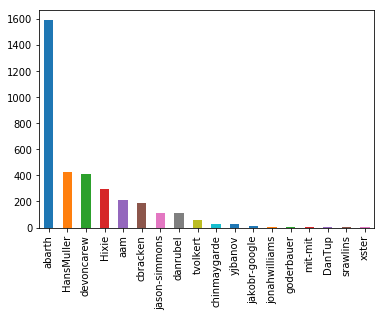

In [228]:
pd.value_counts(preds).plot.bar()